In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from wm import Image as PolarImage
from PIL import Image

In [3]:
from wm.moments import RadialHarmonicFourierMoment
from wm.moments import ZernikeMoment, PseudoZernikeMoment

In [4]:
from wm.metrics import SNR, PSNR

## Embedding

In [5]:
L = 64
# data
np.random.seed(0)
data = np.random.randint(2, size=L)
pos = np.array(range(len(data)))

In [6]:
#data = np.array(list(map(int, '011101110110000101110100011001010111001001101101011000010111001001101011')))

In [7]:
data

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

In [8]:
%%time
W = 128
order = int(np.sqrt(L)*4)
# method
method = RadialHarmonicFourierMoment(order+1, W, Vfile='V_'+'RHFM'+'_'+str(W)+'.h5')
# image
pim = PolarImage('images/monochrome/lena_'+str(W)+'.png', colored=False)
pime = method.encode(pim, data, verbose=True)
im = Image.fromarray(pime.im)

CPU times: user 4.1 s, sys: 494 ms, total: 4.59 s
Wall time: 7.1 s


In [9]:
#im.save(''.join(['lena_',str(W),'_'+method.name+'_','N',str(order),'L',str(L),'.png']))

In [10]:
imdiff = np.abs(pim.im.astype('float16') - pime.im.astype('float16')).astype('uint8')
II = PolarImage(10*imdiff, colored=False)

In [11]:
#Image.fromarray(II.im).save(''.join(['lena_',str(W),'_'+method.name+'_diff_','N',str(order),'L',str(L),'.png']))

PSNR 40.91872133911697 dB


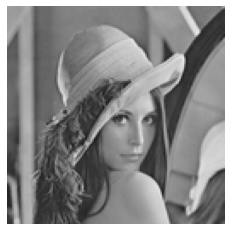

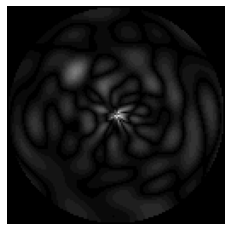

In [12]:
print('PSNR', PSNR(pim.im, pime.im), 'dB')
pime.show()
II.show()

## Benchmarks

In [13]:
from wm.benchmarks.geometry import Resize, Rotate, Flip

In [14]:
# RESIZE
scales = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.5, 2, 3]
bs_resize_nearest = [ Resize(method, data, pos=pos, scale=s, resample=Image.NEAREST, name='Resize/Nearest/'+str(s)) for s in scales ]
bs_resize_linear  = [ Resize(method, data, pos=pos, scale=s, resample=Image.LINEAR,  name='Resize/Linear/'+str(s))  for s in scales ]
bs_resize_bicubic = [ Resize(method, data, pos=pos, scale=s, resample=Image.BICUBIC, name='Resize/Bicubic/'+str(s)) for s in scales ]
bs_resize_lanczos = [ Resize(method, data, pos=pos, scale=s, resample=Image.LANCZOS, name='Resize/Lanczos/'+str(s)) for s in scales ]
# ROTATE
angles = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45]
bs_rotate_nearest = [ Rotate(method, data, pos=pos, angle=a, resample=Image.NEAREST, name='Rotate/Nearest/'+str(a)) for a in angles ]
bs_rotate_linear  = [ Rotate(method, data, pos=pos, angle=a, resample=Image.LINEAR,  name='Rotate/Linear/'+str(a))  for a in angles ]
bs_rotate_bicubic = [ Rotate(method, data, pos=pos, angle=a, resample=Image.BICUBIC, name='Rotate/Bicubic/'+str(a)) for a in angles ]
# FLIP
flips = [Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM]
bs_flip = [ Flip(method, data, pos=pos, direction=d, name='Flip/'+str('UD' if d else 'LR')) for d in flips ]

In [15]:
from wm.benchmarks.noise import Blur, Sharpen, SaltPapperNoise

In [16]:
# GAUSSBLUR
blurs = [1, 2, 3, 4, 5]
bs_blur = [ Blur(method, data, pos=pos, radius=r, name='Blur/'+str(r)) for r in blurs ]
# SHARPEN
sharpens = [5, 10, 20, 30, 40, 50, 100]
bs_sharpen = [ Sharpen(method, data, pos=pos, radius=3, percent=s, name='Sharpen/'+str(s)) for s in sharpens ]
# GAUSSBLUR
sps = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
bs_saltpepper = [ SaltPapperNoise(method, data, pos=pos, amount=a, name='SaltPepper/'+str(a)) for a in sps ]

In [17]:
from wm.benchmarks.compression import JPEG, JPEG2000

In [18]:
# JPEG
qualities = [100, 95, 90, 85, 80, 75, 70, 65, 60, 50, 10, 5]
bs_jpeg = [ JPEG(method, data, pos=pos, quality=q, name='JPEG/'+str(q)) for q in qualities ]
bs_jpeg2000 = [ JPEG2000(method, data, pos=pos, name='JPEG2000') ]

### Run

In [19]:
from functools import reduce
from wm.benchmarks.Benchmark import Benchmark

In [20]:
bs_ = reduce(lambda a,b: a+b, [
    # RESIZE
    #bs_resize_nearest,
    bs_resize_linear,
    #bs_resize_bicubic,
    #bs_resize_lanczos,
    # ROTATE
    #bs_rotate_nearest,
    bs_rotate_linear,
    #bs_rotate_bicubic,
    # FLIP
    bs_flip,
    # NOISE
    #bs_blur,
    #bs_sharpen,
    #bs_saltpepper,
    # COMPRESSION
    bs_jpeg,
    bs_jpeg2000,
], [])

In [21]:
print(Benchmark(method, data, pos=pos)(im))
for b in bs_:
    res = b(im)
    print(''.join([b.name, '\t', str(res)]))

1.0
Resize/Linear/0.2	0.515625
Resize/Linear/0.3	0.5625
Resize/Linear/0.4	0.8125
Resize/Linear/0.5	0.890625
Resize/Linear/0.6	0.984375
Resize/Linear/0.7	1.0
Resize/Linear/0.8	1.0
Resize/Linear/0.9	1.0
Resize/Linear/1.1	1.0
Resize/Linear/1.5	1.0
Resize/Linear/2	1.0
Resize/Linear/3	0.984375
Rotate/Linear/1	1.0
Rotate/Linear/2	1.0
Rotate/Linear/3	1.0
Rotate/Linear/4	1.0
Rotate/Linear/5	1.0
Rotate/Linear/6	1.0
Rotate/Linear/7	1.0
Rotate/Linear/8	1.0
Rotate/Linear/9	1.0
Rotate/Linear/10	1.0
Rotate/Linear/15	1.0
Rotate/Linear/20	1.0
Rotate/Linear/25	1.0
Rotate/Linear/30	1.0
Rotate/Linear/35	1.0
Rotate/Linear/40	1.0
Rotate/Linear/45	1.0
Flip/LR	1.0
Flip/UD	1.0
JPEG/100	1.0
JPEG/95	1.0
JPEG/90	1.0
JPEG/85	1.0
JPEG/80	1.0
JPEG/75	1.0
JPEG/70	1.0
JPEG/65	1.0
JPEG/60	1.0
JPEG/50	1.0
JPEG/10	0.890625
JPEG/5	0.53125
JPEG2000	1.0


In [22]:
method.unloadVfile()